# **CSCI323 Project**

AI-Driven Financial Fraud Detection System

Team Members:

Yash Puri - 7386345 <br>
Teng Ian Khoo - 8121667 <br>
Farooq Ansari - 7758273 <br>
Kimia Mokhtarian - 6756918 <br>

In [ ]:
# importing the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split

# **Loading the data**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sriharshaeedala/financial-fraud-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 178M/178M [00:05<00:00, 34.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sriharshaeedala/financial-fraud-detection-dataset/versions/1


In [ ]:
df = pd.read_csv(path + "/Synthetic_Financial_datasets_log.csv")

# Data Exploration and Preprocessing

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
#Check any null Values
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
#Check Any duplicated values
df.duplicated().sum()

0

In [ ]:
#Lets check the isFlaggeFalse
df['isFlaggedFraud'].value_counts()

,count
isFlaggedFraud,
0,6362604
1,16


This dataset is already very clean, there are no missing values and no duplicated rows; this is expected as it is a synthetic dataset.

First, we decide which columns to drop; in this case I believe nameOrigin and nameDest are just identifiers for accounts; adding this to the model may help the model overfit on the training data by learning which accounts are most involved in fraudulent activities; but will make the model unable to generalize on other data.

I will also be dropping isFlaggedFalse; this is similar to what our model wants to predict(we want to predict isFraud) and this column has only 16 cases Flagged as Fraud and wont be helpful in prediciting Fraud cases.

In [ ]:
#Drop nameOrigin,nameDest and isFalggedFalse
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

# **Feature Engineering**

There might be some useful aggragations or derivations of our data that we can make while the data is still unprocessed that might prove useful for predictions

In [ ]:
#Lets print out all Fraud Transactions
df[df['isFraud'] == 1]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1
251,1,TRANSFER,2806.00,2806.00,0.0,0.00,0.00,1
252,1,CASH_OUT,2806.00,2806.00,0.0,26202.00,0.00,1
680,1,TRANSFER,20128.00,20128.00,0.0,0.00,0.00,1
...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1


Fraudsters often transfer nearly all available funds in an account. This feature captures how much of the sender’s balance is being transferred.Large transaction ratios (~1.0 or higher) → The account is being emptied.

In [ ]:
df["transaction_ratio"] = df["amount"] / (df["oldbalanceOrg"] + 1e-10)

Fraudulent transactions often cause a sharp drop in the sender's balance. This feature helps detect such behavior. If balance_change_ratio ≈ 1, it means nearly the entire balance was withdrawn.

In [ ]:
df["balance_change_ratio"] = (df["oldbalanceOrg"] - df["newbalanceOrig"]) / (df["oldbalanceOrg"] + 1e-10)

Fraudulent transactions often send money to empty accounts; if a transaction suddenly increases an account’s balance from 0 to a large amount, it could be suspicious.

In [ ]:
df["dest_balance_change"] = (df["newbalanceDest"] - df["oldbalanceDest"]) / (df["oldbalanceDest"] + 1e-10)

**NOTE**
The reason we add 1e-10 is because sometimes the denominator might be zero and dividing by zero will give an error; by adding a miniscule number we will not effect the predictions by much if at all.

In [ ]:
#Now lets see the Fraud with our newly addeed features
df[df['isFraud'] == 1]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,transaction_ratio,balance_change_ratio,dest_balance_change
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1,1.0,1.0,0.000000e+00
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1,1.0,1.0,-1.000000e+00
251,1,TRANSFER,2806.00,2806.00,0.0,0.00,0.00,1,1.0,1.0,0.000000e+00
252,1,CASH_OUT,2806.00,2806.00,0.0,26202.00,0.00,1,1.0,1.0,-1.000000e+00
680,1,TRANSFER,20128.00,20128.00,0.0,0.00,0.00,1,1.0,1.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,1.0,1.0,3.396821e+15
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,1.0,1.0,0.000000e+00
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,1.0,1.0,9.215238e+01
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,1.0,1.0,0.000000e+00


Lets Check our target Variable(isFraud) Distribution

In [ ]:
#Let's see how many fraud is in the dataset
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [ ]:
#Lets get that as a percentage
df['isFraud'].value_counts()/len(df) * 100

,count
isFraud,
0,99.870918
1,0.129082


The data is highly imbalanced, 99.8% of the dataset is not Fraud; this means that we will have to handle the Class imbalance using technqiues such as SMOTE or Undersampling the abundant class.

We will have to normalize the data as well.

In [ ]:
!pip install imbalanced-learn

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline # Import Pipeline

In [ ]:
# Define categorical and numerical columns
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_features.remove("isFraud")  # Ensure target is not scaled

Lets plot some histograms and boxplots to help us visualize the distribution and outlier data in our dataset

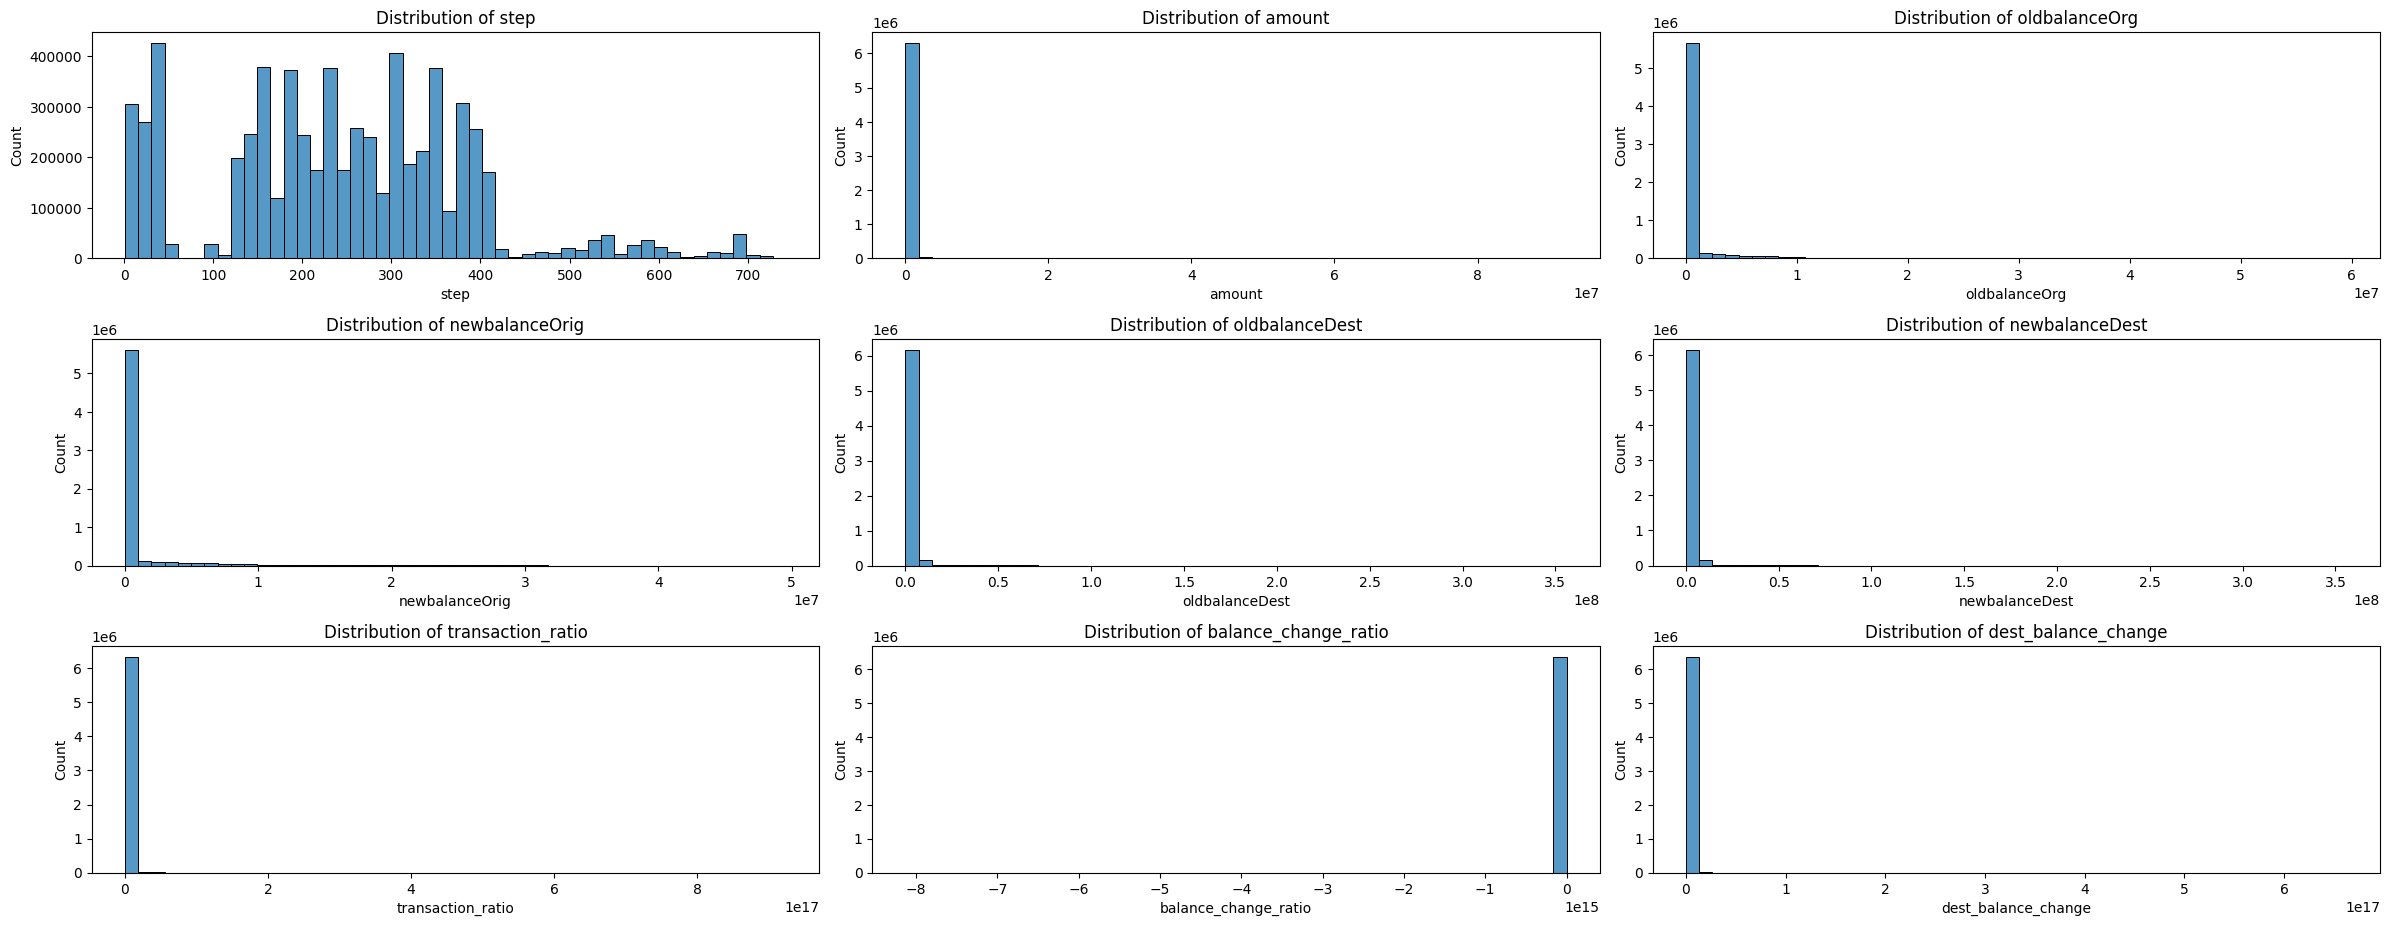

In [ ]:
# Plot histograms for each feature, Takes time
plt.figure(figsize=(24, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[feature], bins=50)
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


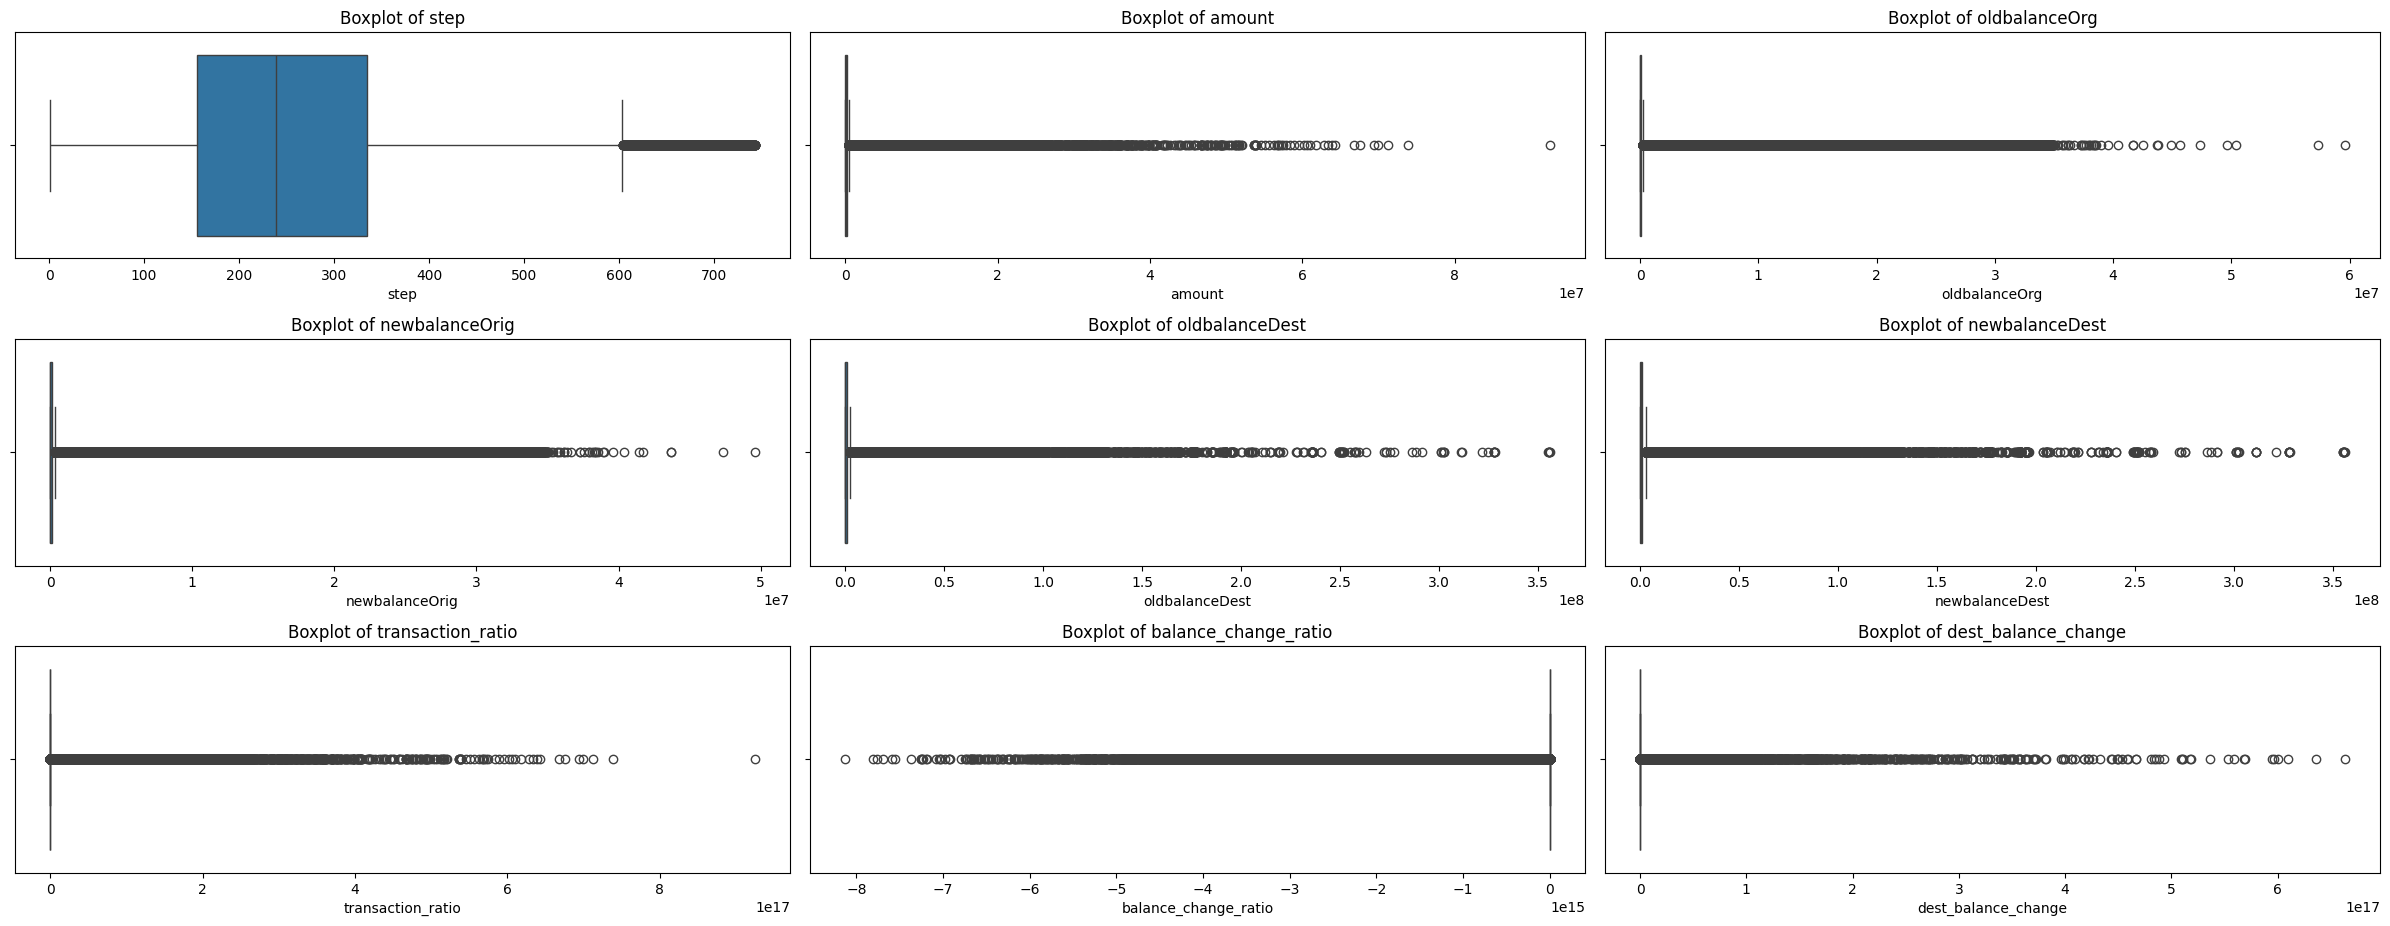

In [ ]:
#Also takes time
plt.figure(figsize=(24, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()


From the Histograms we can see that our data is highly skewed and not normally distributed; there are also a signifigant amount of outlier data as well. This means when scaling we should use a scaling method more suitable for such data such as RobustScaler as opposed to a StandardScaler.

The reasons why we do not deal with the outliers here is because these outliers may simulate transactional data; where the possible ranges of "real" transactions will deviate largely.

In [ ]:
# Create ColumnTransformer for encoding
preprocessor = ColumnTransformer(
    [
        ("num", RobustScaler(), numerical_features),  # More resistant to outliers
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features), #sparse=False for SMOTE
    ]
)

In [ ]:
# Fit and transform the preprocessor on the entire dataset
X_encoded = preprocessor.fit_transform(df.drop(columns=["isFraud"]))

In [ ]:
# Get feature names after OneHotEncoding
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numerical_features + list(encoded_cat_features)

In [ ]:
X_encoded_df = pd.DataFrame(X_encoded, columns=all_features, index=df.index)

# **Saving the Data**

In [ ]:
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folderpath="/content/drive/MyDrive/CSCI323/Project" #change this to your path
#Make the folder if it does not exist
import os
if not os.path.exists(folderpath):
    os.makedirs(folderpath)

In [ ]:
if not os.path.exists(folderpath + '/data.joblib'):
  joblib.dump(X_encoded_df , folderpath + '/data.joblib')
if not os.path.exists(folderpath + '/target.joblib'):
  joblib.dump(df["isFraud"] , folderpath + '/target.joblib')

# **Loading the Saved Data**

In [ ]:
#Run the Mounting Code and Folderpath Code From above first
if os.path.exists(folderpath + '/data.joblib'):
  X_encoded_df = joblib.load(folderpath + '/data.joblib')
if not os.path.exists(folderpath + '/target.joblib'):
  df["isFraud"] = joblib.load(folderpath + '/target.joblib')

# **Data Splitting**

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
# Now, split the encoded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, df["isFraud"], test_size=0.2, stratify=df["isFraud"], random_state=42
)

# **Handling Class Imbalance**

Since the class is highly imbalanced; we need a way or technique to help us overcome the model overfitting on the training data; We can use resampling methods such as SMOTE or SMOTEENN. For our case we will be initally using SMOTE and might consider using other techniques later on.

SMOTE works by creating synthethic samples of the undersampled variable(in this case Fraud samples) this hopefuly helps the model balance it's predictions and not make it too biased.

In [ ]:
# Apply SMOTE only to the training data
smote = SMOTE(sampling_strategy=0.2, random_state=42)

In [ ]:
# Fit and resample
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Test Data Should Represent Real-World Fraud Distribution

SMOTE artificially increases the number of fraud cases. If you apply it to the test set, it will no longer represent the actual fraud distribution in the real world.
This leads to over-optimistic model performance, since the test set will have more fraud cases than expected.


Avoiding Data Leakage

If you apply SMOTE before splitting, synthetic fraud samples will leak into the test set.
The model will then learn from artificially generated fraud cases, making test evaluation unreliable.


In [ ]:
# Check Class Balance After SMOTE
print("Class distribution after SMOTE:\n", pd.Series(y_train_sm).value_counts())

Class distribution after SMOTE:
 isFraud
0    5083526
1    1016705
Name: count, dtype: int64


# Hyperparameter tuning and Model training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

#A Linear Regression Model



| **Hyperparameter** | **What It Does** | **Effect on Model** |
|--------------------|----------------|----------------------|
| `C` | **Regularization strength** (inverse of λ) | Smaller `C` values apply **stronger regularization** (simpler model, less overfitting), while larger `C` values allow **more complexity**. |
| `solver` | **Optimization algorithm for gradient descent** | Some solvers are better for **small datasets (`liblinear`)**, while others work well for **large datasets (`lbfgs`, `saga`)**. |
| `penalty` | **Type of regularization (`l1`, `l2`, `elasticnet`, None)** | - `l1` (Lasso) removes weak features (**feature selection**).<br> - `l2` (Ridge) prevents large coefficients (**reduces overfitting**).<br> - `elasticnet` is a mix of both. |
| `max_iter` | **Maximum number of iterations** | If the model does not converge, increasing `max_iter` allows more steps to **reach an optimal solution**. |
| `class_weight` | **Handles class imbalance** | `"balanced"` adjusts weights **inversely proportional** to fraud cases, helping detect rare fraud transactions. |
| `tol` | **Tolerance for stopping criteria** | Lower values (e.g., `1e-6`) force the algorithm to run **longer but find better solutions**. |


In [ ]:
# Define hyperparameters to tune
#We had to reduce the number of parameters as it was taking so long
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],  # Regularization strength
    "solver": ["liblinear", "lbfgs"],  # Best solvers for fraud data
    "class_weight": ["balanced"]  # Ensures fraud cases are properly weighted
}


# Perform GridSearchCV
grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=1000), param_grid_lr, cv=3, scoring="roc_auc", n_jobs=-1
)

In [ ]:
#Takes a long time to run
grid_search_lr.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'class_weight': ['balanced'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='roc_auc')

In [ ]:
# Best Hyperparameters & Score
print("Best Hyperparameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best ROC-AUC Score:", grid_search_lr.best_score_)

Best Hyperparameters for Logistic Regression: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
Best ROC-AUC Score: 0.8597659567614849


In [ ]:
# Train Final Logistic Regression Model
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.01, class_weight='balanced')

# A RandomForest Model


| **Hyperparameter** | **What It Does** | **Effect on Model** |
|--------------------|----------------|----------------------|
| `n_estimators` | **Number of decision trees in the forest** | More trees **increase accuracy** but also increase **training time**. |
| `max_depth` | **Maximum depth of each tree** | - Deeper trees learn **complex patterns** but may **overfit**.<br> - Shallower trees are **faster** but may **underfit**. |
| `min_samples_split` | **Min samples required to split a node** | Higher values make the model **simpler**, reducing overfitting. |
| `min_samples_leaf` | **Min samples at a leaf node** | - Smaller values allow **more splits**, making the model **complex**.<br> - Larger values **prevent tiny leaves**, improving generalization. |
| `max_features` | **Number of features considered at each split** | - `"sqrt"`: Uses **square root of features**, preventing overfitting.<br> - `"log2"`: Uses **log2(features)**, reducing randomness.<br> - `None`: Uses **all features**, making trees more dependent. |
| `bootstrap` | **Whether to use bootstrapping** | - `True` (default) → Each tree trains on a **random subset** of data.<br> - `False` → Each tree trains on **all data**, making it more deterministic. |
| `class_weight` | **Adjusts fraud vs. non-fraud weights** | `"balanced"` increases focus on **fraud cases**, reducing false negatives. |


In [ ]:
#We had to reduce the number of parameters as it was taking so long
param_grid_rf = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [None, 10, 20],  # Limit depth to avoid overfitting
    "min_samples_split": [2, 5, 10]  # Minimum samples required for node split
}

# Perform GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid_rf, cv=3, scoring="roc_auc", n_jobs=-1
)

In [ ]:
#Takes a long time to run as well(Many Hours)
grid_search_rf.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [ ]:
# Best Hyperparameters & Score
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)
print("Best ROC-AUC Score:", grid_search_rf.best_score_)

Best Hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Best ROC-AUC Score: 0.9999995859281632


In [ ]:
# Train Final Random Forest Model
best_rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
best_rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                       random_state=42)

The ROC AUC score is the area under the ROC curve. It sums up how well a model can produce relative scores to discriminate between positive or negative instances across all classification thresholds.
The ROC AUC score ranges from 0 to 1, where 0.5 indicates random guessing, and 1 indicates perfect performance.

# Deep Learning Models

I want to run at least one deep learning model to compare and contrast ,metrics with our machine learning models

For Deep learning models, we cannot use the defined search algorithms from sklearn. Instead we will use KerasTuner which will provide similar functionality.

https://www.tensorflow.org/tutorials/keras/keras_tuner

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

# CNN model

A 1D Convolutional Neural Network (CNN) is an excellent choice for fraud detection because it automatically learns important patterns from transaction data. Instead of relying on manually engineered features, CNNs can extract relationships between different transaction attributes, improving fraud detection accuracy.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

In [ ]:
# Ensure X_train_sm and y_train have the same number of samples
min_samples = min(X_train_sm.shape[0], y_train.shape[0])

X_train_sm = X_train_sm[:min_samples]
y_train = y_train[:min_samples]

# Reshape for CNN (Adding a channel dimension)
X_train_sm_cnn = np.reshape(X_train_sm, (X_train_sm.shape[0], X_train_sm.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Ensure X_test and y_test also match
min_test_samples = min(X_test_cnn.shape[0], y_test.shape[0])
X_test_cnn = X_test_cnn[:min_test_samples]
y_test = y_test[:min_test_samples]



| **Hyperparameter** | **What It Does** | **Effect on Model** |
|--------------------|----------------|----------------------|
| `filters_1` | **Number of filters in the first Conv1D layer** | More filters extract **more complex fraud patterns**, but too many can cause overfitting. |
| `kernel_size_1` | **Size of the convolution kernel (window size)** | Larger values allow the model to capture **broader fraud trends**, while smaller values focus on local patterns. |
| `dropout_1` | **Dropout rate to reduce overfitting** | Higher values prevent overfitting but can also reduce learning capacity. |
| `dense_units` | **Number of neurons in the fully connected layer** | Controls the complexity of the decision-making layer; too few neurons may miss patterns, while too many may overfit. |
| `optimizer` | **Algorithm to update weights** | `"adam"` is commonly used for fast and adaptive learning. |

---


In [ ]:
def build_cnn_model(hp):
    model = Sequential([
        Conv1D(filters=hp.Int("filters_1", min_value=32, max_value=128, step=32),
               kernel_size=hp.Int("kernel_size_1", min_value=3, max_value=7, step=2),
               activation="relu",
               input_shape=(X_train_sm_cnn.shape[1], 1)),
        Flatten(),
        Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1)),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")  # Fraud classification output
    ])

    model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)
    return model


In [ ]:
#There are a few methods for searching, Hyperband,etc. RandomSearch is the fastest
tuner_cnn = kt.RandomSearch(
    build_cnn_model,  # Your CNN model function
    objective="val_auc",  # Optimizing for AUC score
    max_trials=20,  # Number of different sets of hyperparameters to try
    executions_per_trial=1,  # How many times to evaluate each configuration
    directory="cnn_tuning",  # Where to save logs
    project_name="cnn_fast_tuning"
)

# Run the tuning process, I lowered to number of epochs to 2. Takes too much time otherwise
tuner_cnn.search(X_train_sm_cnn, y_train, validation_data=(X_test_cnn, y_test), epochs=2, batch_size=32)

Trial 20 Complete [00h 13m 40s]
val_auc: 0.9353548884391785

Best val_auc So Far: 0.9531838297843933
Total elapsed time: 04h 34m 10s


In [ ]:
# Get the best CNN model from the tuner
best_cnn = tuner_cnn.get_best_models(num_models=1)[0]

# Print model summary
best_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 12, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,833 (97.00 KB)

 Trainable params: 24,833 (97.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Get the best hyperparameters
best_hyperparameters = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameter values
print("Best CNN Hyperparameters Found:")
for param in best_hyperparameters.values.keys():
    print(f"{param}: {best_hyperparameters.get(param)}")

Best CNN Hyperparameters Found:
filters_1: 32
kernel_size_1: 3
dropout_1: 0.4


In [ ]:
# Train the best model
best_cnn.fit(X_train_sm_cnn, y_train, validation_data=(X_test_cnn, y_test), epochs=5, batch_size=32)

Epoch 1/5
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 407s 3ms/step - auc: 0.9298 - loss: 9250150400.0000 - val_auc: 0.9679 - val_loss: 0.0023
Epoch 2/5
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 394s 2ms/step - auc: 0.9268 - loss: 1266122112.0000 - val_auc: 0.9344 - val_loss: 0.0025
Epoch 3/5
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 396s 2ms/step - auc: 0.9312 - loss: 1171244160.0000 - val_auc: 0.9266 - val_loss: 0.0031
Epoch 4/5
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 397s 2ms/step - auc: 0.9181 - loss: 1249639296.0000 - val_auc: 0.9290 - val_loss: 0.0027
Epoch 5/5
159066/159066 ━━━━━━━━━━━━━━━━━━━━ 396s 2ms/step - auc: 0.9149 - loss: 6191514112.0000 - val_auc: 0.8637 - val_loss: 11362183168.0000


# **Saving The Models**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folderpath="/content/drive/MyDrive/CSCI323/Project" #change this to your path
#Make the folder if it does not exist
import os
if not os.path.exists(folderpath):
    os.makedirs(folderpath)

In [ ]:
# loading dependecy
import joblib

In [ ]:
# saving our model,overwrite if it exists
if best_lr is not None:
  joblib.dump(best_lr , folderpath + '/lr_jlib')

['/content/drive/MyDrive/CSCI323/Project/lr_jlib']

In [ ]:
if best_rf is not None:
  joblib.dump(best_rf , folderpath + '/rf_jlib')

['/content/drive/MyDrive/CSCI323/Project/rf_jlib']

In [ ]:
if  best_cnn is not None:
  joblib.dump(best_cnn , folderpath + '/cnn_jlib')

# **Loading the Trained Models**

In [ ]:
#Load the models from the drive if they exist
if os.path.exists(folderpath + '/lr_jlib'):
  best_lr = joblib.load(folderpath + '/lr_jlib')
if os.path.exists(folderpath + '/rf_jlib'):
  best_rf = joblib.load(folderpath + '/rf_jlib')
if os.path.exists(folderpath + '/cnn_jlib'):
  best_cnn = joblib.load(folderpath + '/cnn_jlib')

# Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, roc_auc_score

In [ ]:
models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
}

In [ ]:
# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...\n")
    y_pred = model.predict(X_test)

    # Model Metrics
    print(f"Model: {name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    print("-" * 50)

Evaluating Logistic Regression...

Model: Logistic Regression
Confusion Matrix:
 [[442456 828425]
 [     3   1640]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.35      0.52   1270881
           1       0.00      1.00      0.00      1643

    accuracy                           0.35   1272524
   macro avg       0.50      0.67      0.26   1272524
weighted avg       1.00      0.35      0.52   1272524

ROC-AUC Score: 0.8632011973685688
--------------------------------------------------
Evaluating Random Forest...

Model: Random Forest
Confusion Matrix:
 [[1270878       3]
 [      4    1639]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00 

# **Logistic Regression**


Class 0 (Negative class) has a high precision (1.00) but low recall (0.35), meaning many actual negatives are misclassified as positives.
Class 1 (Positive class) has extremely low precision (0.00) and perfect recall (1.00), meaning it classifies all actual positives correctly but misclassifies almost all negatives.

Overall accuracy is very low (0.35), meaning the model is mostly misclassifying the majority class (0).
ROC-AUC Score: 0.8632 → This suggests that despite poor classification results, the model has some ability to distinguish between classes.

The model misclassifies too many negatives as positives (high FP rate).
It completely fails at positive class precision.
Low overall effectiveness due to imbalanced class predictions.


# **Random Forest**


Perfect precision, recall, and F1-score for both classes (1.00)
Accuracy is 100%, meaning the model correctly classifies all samples.
ROC-AUC Score: 0.9996, which is extremely high.


The model is highly accurate with almost no misclassifications.
Perfect precision and recall indicate that the model can effectively differentiate between the two classes.

If this is real-world data, a perfect score might indicate overfitting, meaning the model may not generalize well to unseen data. It is Overfitted to the training data

Random Forest significantly outperforms Logistic Regression in every metric.
Logistic Regression is struggling with class imbalance, leading to poor recall for class 0 and zero precision for class 1.

Random Forest appears too good to be true—it might be overfitting.

# **Feature Importance**

Since we used a Random Forest we can get the feature importance of the model.

Feature importance is a technique used to determine which features contribute most to a model’s predictions , where the importance score represents how much a feature reduces uncertainty (impurity) in the model.

Higher feature importance means:

The feature plays a significant role in predictions.
Removing it might negatively impact model performance.

In [ ]:
import pandas as pd

# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importance.head(10))


                 Feature  Importance
6      transaction_ratio    0.323628
7   balance_change_ratio    0.179840
2          oldbalanceOrg    0.099279
1                 amount    0.098024
3         newbalanceOrig    0.075511
13         type_TRANSFER    0.060088
0                   step    0.049831
8    dest_balance_change    0.036402
5         newbalanceDest    0.032698
4         oldbalanceDest    0.015823


As above 2/3 of our added features (transaction_ratio and balance_change_ratio) was considered to be the most impactful feature to help identify Fraud cases

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Get predictions
y_probs = best_cnn.predict(X_test_cnn)  # Probabilities
y_pred = (y_probs > 0.5).astype(int)  # Convert probabilities to binary

# Print Evaluation Metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

39767/39767 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step
Confusion Matrix:
 [[1270862      19]
 [    704     939]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.57      0.72      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.79      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.8537018559177282


The model performs well, it has high accuracy; it almost never misclassifies non-fraud cases. But that is because Fraud cases are rare.

Compared to the Random Forestit performs worse; it misclassifies fraud cases 43% of the time.

From our testing the Random Forest is the best performing model compared to the rest; however the trad off is that the training of the Random Forest is much longer than the other methods; the size of the model is also much larger (18.3 MB vs 321KB and 2KB) compared to the CNN and Logistic model respectively.